# CEDA and **odc-stac**

Minimal reproducible example of using [odc-stac](https://github.com/opendatacube/odc-stac) with the [CEDA STAC API](https://api.stac.ceda.ac.uk/).
I like using [uv](https://docs.astral.sh/uv/) to manage my Python dependencies:

```shell
uv venv
source .venv/bin/activate
uv pip install ipykernel odc-stac pystac-client pystac[jinja2] rasterio dask[distrubuted] bokeh rioxarray
```

`pystac[jinja2]` enables pretty-printing of **pystac** items.

In [1]:
import os

import dask.distributed
import odc.stac
import rasterio
from pystac.extensions.raster import RasterBand
from pystac_client import Client

In [2]:
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = (
    "1"  # this is to silence some yelling for @gadomski
)

client = dask.distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37879,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:44889,Total threads: 1
Dashboard: http://127.0.0.1:36553/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:39081,


In [3]:
client = Client.open("https://api.stac.ceda.ac.uk/")
item_collection = client.search(
    collections=["sentinel2_ard"],
    intersects={"type": "Point", "coordinates": [-1.3144, 51.5755]},
    sortby="-properties.datetime",
    max_items=10,
).item_collection()
item_collection

In [4]:
item_collection = client.search(
    collections=["sentinel2_ard"],
    intersects={"type": "Point", "coordinates": [-1.3144, 51.5755]},
    sortby="-properties.datetime",
    max_items=10,
).item_collection()
item_collection

A naïve load raises an exception.

In [4]:
odc.stac.load(item_collection)

ValueError: Failed to auto-guess CRS/resolution.

The STAC items don't have the projection or raster extensions, so **odc-stac** will refuse to compute the "geobox" 😔.
**odc-stac** pretty opinionated on what STAC items and assets should look like.
Let's add those extensions.

In [6]:
for item in item_collection.items:
    asset = item.assets["cog"]
    cog = rasterio.open(asset.href)
    epsg = cog.crs.to_epsg()
    dtypes = cog.dtypes
    shape = cog.shape
    transform = list(cog.transform)

    item.ext.add("proj")
    item.ext.add("raster")

    item.ext.proj.epsg = epsg

    cog = item.assets["cog"]
    cog.ext.raster.bands = [RasterBand.create(data_type=dtype) for dtype in dtypes]
    cog.ext.proj.shape = shape
    cog.ext.proj.transform = transform
item_collection

Now it should work!
We pass `chunks={}` to enable Dask.

In [18]:
bbox = [-1.2, 51.6, -1.1, 51.7]
dataset = odc.stac.load(item_collection, bands=("red", "green", "blue"), chunks={}, bbox=bbox)
dataset

<xarray.Dataset> Size: 48MB
Dimensions:      (y: 1121, x: 706, time: 10)
Coordinates:
  * y            (y) float64 9kB 2.005e+05 2.005e+05 ... 1.893e+05 1.893e+05
  * x            (x) float64 6kB 4.554e+05 4.554e+05 ... 4.624e+05 4.624e+05
    spatial_ref  int32 4B 27700
  * time         (time) datetime64[ns] 80B 2023-10-03T11:08:09 ... 2023-11-20...
Data variables:
    red          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1121, 706), meta=np.ndarray>
    green        (time, y, x) uint16 16MB dask.array<chunksize=(1, 1121, 706), meta=np.ndarray>
    blue         (time, y, x) uint16 16MB dask.array<chunksize=(1, 1121, 706), meta=np.ndarray>

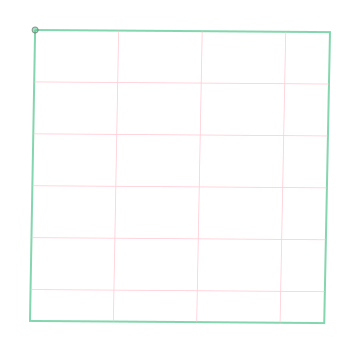

In [19]:
dataset.odc.geobox

In [20]:
dataset = dataset.compute()
dataset

<xarray.Dataset> Size: 48MB
Dimensions:      (y: 1121, x: 706, time: 10)
Coordinates:
  * y            (y) float64 9kB 2.005e+05 2.005e+05 ... 1.893e+05 1.893e+05
  * x            (x) float64 6kB 4.554e+05 4.554e+05 ... 4.624e+05 4.624e+05
    spatial_ref  int32 4B 27700
  * time         (time) datetime64[ns] 80B 2023-10-03T11:08:09 ... 2023-11-20...
Data variables:
    red          (time, y, x) uint16 16MB 435 442 452 466 ... 391 384 398 437
    green        (time, y, x) uint16 16MB 425 431 446 479 ... 377 368 378 408
    blue         (time, y, x) uint16 16MB 417 432 475 535 ... 354 346 345 352

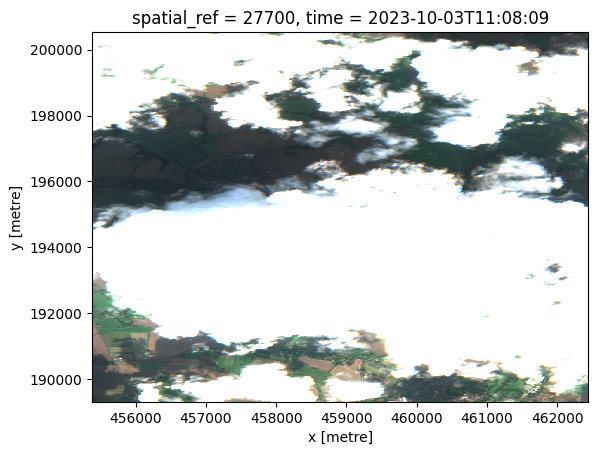

In [27]:
_ = dataset.isel(time=0).to_array("band").plot.imshow(vmin=0, vmax=256)